In [1]:
import tushare as ts

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

In [4]:
data = ts.get_hist_data('600502')
data = data.reset_index().sort_values('date')
data = data.reset_index()
data

,index,date,open,high,close,low,volume,price_change,p_change,ma5,ma10,ma20,v_ma5,v_ma10,v_ma20
0,605,2017-11-20,7.00,7.03,7.02,6.88,66324.21,0.03,0.43,7.020,7.020,7.020,66324.21,66324.21,66324.21
1,604,2017-11-21,7.02,7.06,6.95,6.92,93960.63,-0.06,-0.86,6.985,6.985,6.985,80142.42,80142.42,80142.42
2,603,2017-11-22,6.95,7.02,6.94,6.91,70130.89,-0.01,-0.14,6.970,6.970,6.970,76805.24,76805.24,76805.24
3,602,2017-11-23,6.94,7.02,6.97,6.88,89104.76,0.03,0.43,6.970,6.970,6.970,79880.12,79880.12,79880.12
4,601,2017-11-24,6.96,6.96,6.90,6.86,69758.39,-0.06,-0.86,6.956,6.956,6.956,77855.78,77855.78,77855.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
601,4,2020-05-13,3.93,3.97,3.95,3.92,45769.19,0.00,0.00,3.964,3.927,3.982,100672.10,111996.41,186521.25
602,3,2020-05-14,3.95,3.95,3.88,3.87,96212.20,-0.07,-1.77,3.950,3.917,3.979,98534.32,109134.85,185246.49
603,2,2020-05-15,3.89,3.91,3.85,3.84,88444.92,-0.03,-0.77,3.928,3.919,3.972,97863.80,98255.39,182579.30
604,1,2020-05-18,3.88,3.91,3.86,3.84,73655.95,0.01,0.26,3.898,3.924,3.968,80435.05,97087.15,180826.43


In [5]:
data['date'] = data['date'].astype('M8[D]')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 606 entries, 0 to 605
Data columns (total 15 columns):
index           606 non-null int64
date            606 non-null datetime64[ns]
open            606 non-null float64
high            606 non-null float64
close           606 non-null float64
low             606 non-null float64
volume          606 non-null float64
price_change    606 non-null float64
p_change        606 non-null float64
ma5             606 non-null float64
ma10            606 non-null float64
ma20            606 non-null float64
v_ma5           606 non-null float64
v_ma10          606 non-null float64
v_ma20          606 non-null float64
dtypes: datetime64[ns](1), float64(13), int64(1)
memory usage: 71.1 KB


In [6]:
# 传入时间,假设为当前日期,根据已知数据,返回策略
def profit(mdate):
    """
    基于均线理论,判断金叉死叉,返回响应结果
    """
    mask = data['date'] <= mdate
    if len(data[mask]) < 2:
        return 0
    today_data = data[mask].iloc[-1]
    yesday_data = data[mask].iloc[-2]
    #  昨天的5日均线与10日均线
    yma5, yma10 = yesday_data['ma5'], yesday_data['ma10']
    #  今天的5日均线与10日均线
    tma5, tma10 = today_data['ma5'], today_data['ma10']

    if (yma10 >= yma5) and (tma10 <= tma5):
        return 1
    elif (yma10 <= yma5) and (tma10 >= tma5):
        return -1
    return 0

In [7]:
profit_vec=np.vectorize(profit)

In [8]:
result = profit_vec(data['date'])
(result == 1).sum()

34

In [9]:
assets = 1000000
stocks = 0
payment_price = 0
status = 0
for index, profit in enumerate(result):
    current_price = data['close'][index]
    # 如果是买入并且赔了的状态，若已经跌出5%，则强制卖出
    if status == 1:
        payment_assets = payment_price * stocks
        current_assets = current_price * stocks
        if (payment_assets > current_assets) and (
            (payment_assets - current_assets) > payment_assets * 0.05):
            payment_price = current_price
            assets = assets + stocks * payment_price
            stocks = 0
            status = -1
            print('止损：dates:{}, curr price:{:.2f}, assets:{:.2f}, stocks:{:d}'.
                  format(data['date'][index], current_price, assets, stocks))
    if (profit == 1) and (status != 1):  # 买入
        payment_price = current_price
        stocks = int(assets / payment_price)
        assets = assets - stocks * payment_price
        status = 1
        print('买入：dates:{}, curr price:{:.2f}, assets:{:.2f}, stocks:{:d}'.
              format(data['date'][index], current_price, assets, stocks))
    if (profit == -1) and (status != -1):  # 卖出
        payment_price = current_price
        assets = assets + stocks * payment_price
        stocks = 0
        status = -1
        print('卖出：dates:{}, curr price:{:.2f}, assets:{:.2f}, stocks:{:d}'.
              format(data['date'][index], current_price, assets, stocks))
    print('持有：dates:{}, curr price:{:.2f}, assets:{:.2f}, stocks:{:d}'.format(
        data['date'][index], current_price, assets, stocks))

持有：dates:2017-11-20 00:00:00, curr price:7.02, assets:1000000.00, stocks:0
买入：dates:2017-11-21 00:00:00, curr price:6.95, assets:6.20, stocks:143884
持有：dates:2017-11-21 00:00:00, curr price:6.95, assets:6.20, stocks:143884
持有：dates:2017-11-22 00:00:00, curr price:6.94, assets:6.20, stocks:143884
持有：dates:2017-11-23 00:00:00, curr price:6.97, assets:6.20, stocks:143884
持有：dates:2017-11-24 00:00:00, curr price:6.90, assets:6.20, stocks:143884
卖出：dates:2017-11-27 00:00:00, curr price:6.86, assets:987050.44, stocks:0
持有：dates:2017-11-27 00:00:00, curr price:6.86, assets:987050.44, stocks:0
持有：dates:2017-11-28 00:00:00, curr price:6.97, assets:987050.44, stocks:0
持有：dates:2017-11-29 00:00:00, curr price:6.95, assets:987050.44, stocks:0
持有：dates:2017-11-30 00:00:00, curr price:6.98, assets:987050.44, stocks:0
持有：dates:2017-12-01 00:00:00, curr price:7.01, assets:987050.44, stocks:0
买入：dates:2017-12-04 00:00:00, curr price:6.89, assets:2.82, stocks:143258
持有：dates:2017-12-04 00:00:00, curr pr

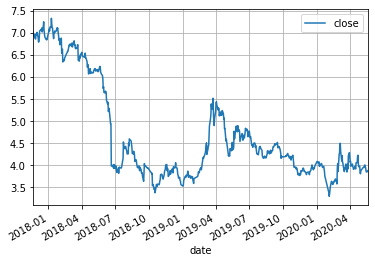

In [10]:
data.plot(x='date', y='close', grid=True)